In [3]:
# General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Pre-processing related imports
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import ngrams
from collections import Counter
import nltk.collocations
import re
import gensim
from gensim.utils import simple_preprocess

# Modelling Imports
import sklearn
import sklearn.metrics
import sklearn.naive_bayes
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Useful relative paths
data_directory = './data/NELA'
model_directory ='./models'

# 1. – Exploration of dataset

In [48]:
df_true = pd.read_csv('{}/true.csv'.format(data_directory))
df_false = pd.read_csv('{}/false.csv'.format(data_directory))

In [50]:
X = pd.concat([df_true,df_false])
from sklearn.utils import shuffle
X = shuffle(X,random_state=0)

## 1.1 See a few instance and column *names*

In [51]:
X.head(5)

,Unnamed: 0,author,collection_utc,content,date,id,published,published_utc,source,title,url,label
17847,17847,NaN,1567550262,A Dublin Castle security man who lost control ...,2019-01-30,theirishtimes--2019-01-30--Dublin Castle secur...,2019-01-30 21:16:44+00:00,1548901004,theirishtimes,Dublin Castle security man guilty of work plac...,https://www.irishtimes.com/news/crime-and-law/...,1
5591,5591,"Chris Strohm, Shannon Pettypiece, Bloomberg",1567540886,President Donald Trump has asserted executive ...,2019-05-08,fortune--2019-05-08--Trump Asserts Executive P...,2019-05-08 14:45:04+00:00,1557341104,fortune,Trump Asserts Executive Privilege Over All Mue...,http://fortune.com/2019/05/08/trump-executive-...,1
11614,11614,NaN,1567549621,This is adapted from Beast special corresponde...,2019-02-04,thedailybeast--2019-02-04--Were in the Age of ...,2019-02-04 10:14:51+00:00,1549293291,thedailybeast,We’re in the Age of Fracture. Here’s How We St...,http://feedproxy.google.com/~r/thedailybeast/a...,1
12385,12385,admin,1567536198,Mayor Pete Buttigieg warned Saturday of the ri...,2019-07-22,prisonplanet--2019-07-22--Pete Buttigieg White...,2019-07-22 12:15:51+00:00,1563812151,prisonplanet,Pete Buttigieg: White Supremacy Threatens to E...,https://www.prisonplanet.com/pete-buttigieg-wh...,0
10455,10455,Josh Kovensky,1575937045,Justice Department Inspector General Michael H...,2019-12-09,talkingpointsmemo--2019-12-09--The Top Five ‘D...,"Mon, 09 Dec 2019 23:01:17 +0000",1575950477,talkingpointsmemo,The Top Five ‘Deep State’ Conspiracy Theories ...,https://talkingpointsmemo.com/muckraker/the-to...,1


In [52]:
X.columns

Index(['Unnamed: 0', 'author', 'collection_utc', 'content', 'date', 'id',
       'published', 'published_utc', 'source', 'title', 'url', 'label'],
      dtype='object')

In [53]:
X=X.drop(labels=['Unnamed: 0', 'author','collection_utc','id','published','published_utc','url' ],axis=1)
df_true=df_true.drop(labels=['Unnamed: 0', 'author','collection_utc','id','published','published_utc','url' ],axis=1)
df_false=df_false.drop(labels=['Unnamed: 0', 'author','collection_utc','id','published','published_utc','url' ],axis=1)

## 1.2 Distribution of labels

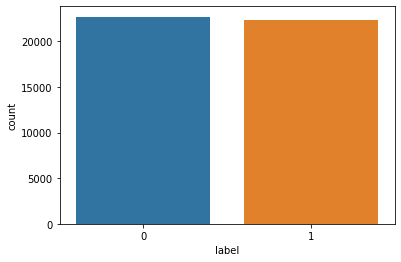

In [18]:
sns.countplot(x=X['label'])

Quite balanced!

## 1.3 Null values

In [19]:
X.isnull().sum()

content    0
date       0
source     0
title      1
label      0
dtype: int64

## 1.4 See example of first news it classifies as "Fake" 

In [52]:
print('title 1: '+X[X.label==0]['title'][1])
print('content 1: '+X[X.label==0]['content'][1])

KeyError: 1

### We make the following remarks:

*   Fake articles are "genuine" fake news, in the sense that they are raw and not specifially pointed out as fake news (as is the case in Politifact.com datasets)
*   Articles seem quite long and and representative of actual content. 



## 1.5 Save this CSV as our unprocessed basis

In [54]:
X.to_csv('{}/complete_unprocessed.csv'.format(data_directory))

# 2. – Data Pre-processing

## 2.1 Check remaing NA values

In [55]:
X.isnull().sum()

content    0
date       0
source     0
title      1
label      0
dtype: int64

In [56]:
X=X.dropna()
df_true=df_true.dropna()
df_false=df_false.dropna()

## 2.2 New feature combining title and content

In [57]:
X['full_content'] = X['title']+X['content']
df_true['full_content'] = df_true['title']+df_true['content']
df_false['full_content'] = df_false['title']+df_false['content']

## 2.3 Define & apply preprocessing function to this new feature

In [58]:
nltk.download("stopwords")
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/axelbogos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/axelbogos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/axelbogos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [59]:
def preprocess(text):
    text=text.lower()
    text= re.sub('[^A-Za-z ]+','', text )
    tokenized_text = nltk.word_tokenize(text)
    tokenized_text = [word for word in tokenized_text if not word in stop_words and len(word)>1]
    tokenized_text =[lemmatizer.lemmatize(word) for word in tokenized_text] 
    result = ' '.join(tokenized_text)
    return result

In [60]:
X['full_preprocessed']=X['full_content'].apply(preprocess)
df_true['full_preprocessed']=df_true['full_content'].apply(preprocess)
df_false['full_preprocessed']=df_false['full_content'].apply(preprocess)

## 2.4 Get Most Common Bigrams before and after pre-processing (long to run, careful)

In [61]:
# True articles. Comment out if only want overall dataset bigrams
true_content_bigrams=df_true['full_content'].apply(lambda x: x.split())
true_processed_bigrams=df_true['full_preprocessed'].apply(lambda x: x.split())
# False articles. Comment out if only want overall dataset bigrams
false_content_bigrams=df_false['full_content'].apply(lambda x: x.split())
false_processed_bigrams=df_false['full_preprocessed'].apply(lambda x: x.split())

full_content_bigrams=X['full_content'].apply(lambda x: x.split())
full_processed_bigrams=X['full_preprocessed'].apply(lambda x: x.split())

### 2.4.1 Before Pre-processing

#### 2.4.1.1 True Articles Before Pre-processing

In [62]:
finder = BigramCollocationFinder.from_documents(true_content_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in true_content_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(of, the)",68437
1,"(in, the)",56891
2,"(to, the)",31368
3,"(on, the)",24360
4,"(for, the)",20416
5,"(at, the)",17673
6,"(to, be)",17666
7,"(and, the)",16981
8,"(in, a)",16529
9,"(with, the)",14724


#### 2.4.1.2 False Articles Before Pre-processing

In [63]:
finder = BigramCollocationFinder.from_documents(false_content_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in true_content_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(of, the)",68437
1,"(in, the)",56891
2,"(to, the)",31368
3,"(on, the)",24360
4,"(for, the)",20416
5,"(at, the)",17673
6,"(to, be)",17666
7,"(and, the)",16981
8,"(in, a)",16529
9,"(with, the)",14724


#### 2.4.1.3 Full dataset Before Pre-processing

In [44]:
finder = BigramCollocationFinder.from_documents(full_content_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in full_content_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(of, the)",143818
1,"(in, the)",110533
2,"(to, the)",66235
3,"(on, the)",46505
4,"(for, the)",38645
5,"(and, the)",36492
6,"(to, be)",34443
7,"(that, the)",33354
8,"(at, the)",32506
9,"(in, a)",29826


### 2.4.2 After Pre-processing

#### 2.4.2.1 True Articles After Pre-processing

In [64]:
finder = BigramCollocationFinder.from_documents(true_processed_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in true_processed_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(donald, trump)",3860
1,"(white, house)",3806
2,"(united, state)",3610
3,"(new, york)",3354
4,"(last, year)",3236
5,"(prime, minister)",2968
6,"(president, donald)",2177
7,"(per, cent)",2030
8,"(last, week)",1882
9,"(president, trump)",1677


#### 2.4.2.2 False Articles After Pre-processing

In [65]:
finder = BigramCollocationFinder.from_documents(false_processed_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in false_processed_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(united, state)",6368
1,"(donald, trump)",5687
2,"(new, york)",5141
3,"(president, trump)",5098
4,"(white, house)",4251
5,"(social, medium)",2521
6,"(president, donald)",2520
7,"(last, year)",1941
8,"(trump, administration)",1928
9,"(prime, minister)",1793


#### 2.4.2.3 Full dataset After Pre-processing

In [46]:
finder = BigramCollocationFinder.from_documents(full_processed_bigrams.values)
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder.apply_freq_filter(1)
ngram_list = [pair for row in full_processed_bigrams for pair in ngrams(row, 2)]
counts = Counter(ngram_list).most_common(15)
pd.DataFrame.from_records(counts, columns=['gram', 'count'])

,gram,count
0,"(united, state)",9969
1,"(donald, trump)",9539
2,"(new, york)",8487
3,"(white, house)",8053
4,"(president, trump)",6743
5,"(last, year)",4814
6,"(prime, minister)",4755
7,"(president, donald)",4681
8,"(social, medium)",4150
9,"(trump, administration)",3585


## 2.5 Verify Distribution of length of entries, and remove outliers

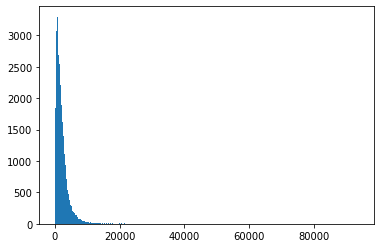

In [66]:
plt.hist([len(x) for x in X['full_preprocessed']], bins=500)
plt.show()

In [19]:
print('Percent of entries with atleast 10,000 words: {}%'.format(round(len([x for x in X['full_preprocessed'] if len(x) >=10000])*100/X.shape[0],3)))
print('Percent of entries with atleast 8000 words: {}%'.format(round(len([x for x in X['full_preprocessed'] if len(x) >=8000])*100/X.shape[0],3)))

Percent of entries with more than 10,000 words: 1.378
Percent of entries with more than 8000 words: 2.505


In [73]:
X=X[X['full_preprocessed'].apply(lambda x: len(x) < 10000)]

## 2.6 Save processed dataframe as csv

In [90]:
X.to_csv('{}/complete_processed.csv'.format(data_directory))

## 2.7 – Store Current X and y values for reccurent use

In [ ]:
y = X['label']
X.drop('label',axis=1)

### 3 – Naive-Bayes Bag of Word Baseline

Retrieve X and y if runtime is disconnected

In [8]:
X = pd.read_csv('{}/complete_processed.csv'.format(data_directory))
y = X['label']
X.drop('label',axis=1)
;

''

In [9]:
feature_pipeline = Pipeline([
                             ('vect', CountVectorizer()), 
                             ('norm', sklearn.preprocessing.Normalizer())
])
X_vectorized = feature_pipeline.fit_transform(X['full_preprocessed'].to_numpy())

In [10]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_vectorized, y, test_size=0.2, random_state=0)

In [12]:
%%time
gnb_classifier = sklearn.naive_bayes.MultinomialNB()
X_train_test = X_train
y_train_test = y_train
gnb_classifier.fit(X_train_test,y_train_test )
y_pred = gnb_classifier.predict(X_test)
print('Baseline: '+classification_report(y_test, y_pred))

Baseline:               precision    recall  f1-score   support

           0       0.75      0.86      0.80      4484
           1       0.83      0.70      0.76      4299

    accuracy                           0.78      8783
   macro avg       0.79      0.78      0.78      8783
weighted avg       0.79      0.78      0.78      8783

CPU times: user 180 ms, sys: 26.3 ms, total: 206 ms
Wall time: 368 ms


### Not so bad! And extremely fast

In [13]:
filename = '{}/TFID/baseline_gnb.pkl'.format(model_directory)
pickle.dump(gnb_classifier, open(filename, 'wb'))